# Store Images on GCS

In [ ]:
%%bigquery df

SELECT * FROM `demos_us.etsy`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
!gsutil mb gs://vtxdemos-fstoresearch-datasets

Creating gs://vtxdemos-fstoresearch-datasets/...


In [ ]:
from google.cloud import storage
import requests
import os
from urllib.parse import urlparse

bucket_name = "vtxdemos-fstoresearch-datasets"

public_gcs_link = []
private_gcs_link = []
public_cdn_link = []

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

for index, row in df.iterrows():
  url = row["image_url"]
  parsed_url = urlparse(url)
  filename = os.path.basename(parsed_url.path)
  response = requests.get(url)
  blob = bucket.blob("etsy/"+filename)
  blob.upload_from_string(response.content, content_type='image/jpeg')
  public_gcs_link.append(blob.public_url)
  private_gcs_link.append(f"gs://{bucket_name}/etsy/{filename}")
  public_cdn_link.append(f"https://gcpetsy.sonrobots.net/etsy/{filename}")

df["public_gcs_link"] = public_gcs_link
df["private_gcs_link"] = private_gcs_link
df["public_cdn_link"] = public_cdn_link

In [ ]:
df

,listing_id,title,price_usd,description,tags,materials,attributes,image_url,public_gcs_link,private_gcs_link,public_cdn_link
0,1704754773,Natural Apache Gold Gemstone Cabochon Apache G...,2.00,Natural Apache Gold Gemstone Cabochon Apache G...,"IMMACULTE GEMSTONE, ALLCABOCHON, REAL GEMSTONE...",Natural Apache Gold,holiday: Hanukkah; jewelry theme: Love & frien...,https://img.etsystatic.com/il/d4c561/592688332...,https://storage.googleapis.com/vtxdemos-fstore...,gs://vtxdemos-fstoresearch-datasets/etsy/il_57...,https://gcpetsy.sonrobots.net/etsy/il_570xN.59...
1,1602208141,Pink Faceted Teardrop Acrylic Beads 12mm 12 Beads,2.00,These pink faceted teardrop acrylic beads are ...,"pink teardrop beads, pink beads, acrylic beads...",acrylic,"whenmade: 2020,2023; craft type: Macrame, Jewe...",https://img.etsystatic.com/il/2eebd4/546500926...,https://storage.googleapis.com/vtxdemos-fstore...,gs://vtxdemos-fstoresearch-datasets/etsy/il_57...,https://gcpetsy.sonrobots.net/etsy/il_570xN.54...
2,939031252,"24k Gold Plated Zirconia Semi Circle Jewelry, ...",2.00,"24k Gold Plated Zirconia Semi Circle Jewelry, ...","Cubic Zirconia, Semi Circle Necklace, CZ Mikro...",brass,"whomade: i_did; issupply: 1; whenmade: 2020,20...",https://img.etsystatic.com/il/635b4f/288152953...,https://storage.googleapis.com/vtxdemos-fstore...,gs://vtxdemos-fstoresearch-datasets/etsy/il_57...,https://gcpetsy.sonrobots.net/etsy/il_570xN.28...
3,218183284,Bead Pattern Peyote(Bracelet Cuff)-Victorian P...,2.00,I use Miyuki Delica seed beads size 11 for my ...,"beading, jewelry, peyote graph, peyote pattern...",None,issupply: 1; searchissupply: 0; itemdimensions...,https://img.etsystatic.com/il/963d60/711071755...,https://storage.googleapis.com/vtxdemos-fstore...,gs://vtxdemos-fstoresearch-datasets/etsy/il_57...,https://gcpetsy.sonrobots.net/etsy/il_570xN.71...
4,1007247047,Tiny Heart Charms Clear CZ Micro Pave Shinny H...,2.00,★Please conv. us if you need quantity discount...,"CZ Beads, DIY Beads, tatted jewelry, daith jew...","Crystals, Brass, Cubic Zirconia",issupply: 1; listing_source_detail: web; whenm...,https://img.etsystatic.com/il/468c51/308510615...,https://storage.googleapis.com/vtxdemos-fstore...,gs://vtxdemos-fstoresearch-datasets/etsy/il_57...,https://gcpetsy.sonrobots.net/etsy/il_570xN.30...
...,...,...,...,...,...,...,...,...,...,...,...
195,1518119752,Folk Art Throw Pillow Unicorn Skull Colorful D...,19.88,This attractive pillow makes a statement and s...,"home décor, housewarming gift, new home gift, ...",None,issupply: 0; listingtype: physical; isnotcusto...,https://img.etsystatic.com/il/b9fad6/513035449...,https://storage.googleapis.com/vtxdemos-fstore...,gs://vtxdemos-fstoresearch-datasets/etsy/il_57...,https://gcpetsy.sonrobots.net/etsy/il_570xN.51...
196,958282385,"Gold Rose Cross Necklace, Rose Cross Pendant, ...",1.93,"★Gold Rose Cross Necklace, Rose Cross Pendant,...","Cross Charm, cross pendant, gold plated cross,...","Brass, 18K filled gold, 18K gold plated, cubic...",ispersonalizable: 0; listing_source_detail: we...,https://img.etsystatic.com/il/16a062/290176026...,https://storage.googleapis.com/vtxdemos-fstore...,gs://vtxdemos-fstoresearch-datasets/etsy/il_57...,https://gcpetsy.sonrobots.net/etsy/il_570xN.29...
197,761693531,"DropDuo, CRYSTAL COPPER RAINBOW Matte, Czech ...",1.93,"Coupon CODE: 3OFF30, 50FF50, 10OFF100\nCheck...","glass, glass beads, beautiful, beadweaving, je...",dropduo,isnotcustomizable: 1; itemweightunit: oz; issu...,https://img.etsystatic.com/il/930d8e/247130507...,https://storage.googleapis.com/vtxdemos-fstore...,gs://vtxdemos-fstoresearch-datasets/etsy/il_57...,https://gcpetsy.sonrobots.net/etsy/il_570xN.24...
198,1058103272,J. Cole Poster | 4 Your Eyez Only | Album Cove...,22.42,Product Overview:\nOur prints are a perfect ad...,"Album Cover, Album Poster, Album Print, Home D...",Matte Paper,"originalstate: active; whenmade: 2020,2022; is...",https://img.etsystatic.com/il/576566/397449642...,https://storage.googleapis

In [ ]:
from google.cloud import bigquery

bq_client = bigquery.Client()
job_config = bigquery.LoadJobConfig()
job = bq_client.load_table_from_dataframe(
    df, "demos_us.etsy-images", job_config=job_config
)
job.result()

LoadJob<project=vtxdemos, location=US, id=39673464-432d-4cc8-bcfa-d431a236e268>

## Create Unstructured Data Table with Images (BigLake)

In [ ]:
%%bigquery
CREATE OR REPLACE EXTERNAL TABLE
  `demos_us.vtxdemos-etsy-images-09042024`
WITH CONNECTION `us.emb_connection`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['gs://vtxdemos-fstoresearch-datasets/etsy/*']
  );

Query is running:   0%|          |

""


### Using Text Embeddings and Multimodal Embeedings

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE
  `demos_us.etsy-embeddings-full` AS (
  WITH
    text_embeddings AS (
    SELECT
      *
    FROM
      ML.GENERATE_TEXT_EMBEDDING(MODEL demos_us.text_embedding_044,
        (
        SELECT
          *,
          (CONCAT( "listing id: ", IFNULL(CAST(listing_id AS STRING), ""), " title of the listing: ", IFNULL(title, ""), " the price in US dollars: ", IFNULL(CAST(price_usd AS STRING), ""), " the description of the listing: ", IFNULL(description, ""), " tags used for filter: ", IFNULL(tags, ""), " the materials item was made of: ", IFNULL(materials, ""), ", the attributes: ", IFNULL(attributes, "") )) AS content
        FROM
          `vtxdemos.demos_us.etsy-images`
        WHERE
          private_gcs_link = "gs://vtxdemos-fstoresearch-datasets/etsy/il_570xN.2163311614_dj39.jpg"
        ORDER BY
          private_gcs_link )) ),
    image_embeddings AS (
    SELECT
      *
    FROM
      ML.GENERATE_EMBEDDING( MODEL `vtxdemos.demos_us.multimodalembedding`,
        TABLE `demos_us.vtxdemos-etsy-images-09042024`,
        STRUCT( TRUE AS flatten_json_output ) )
    ORDER BY
      uri)
  SELECT
    *
  FROM
    text_embeddings te
  INNER JOIN
    image_embeddings ie
  ON
    te.private_gcs_link = ie.uri )

In [ ]:
%%bigquery
  SELECT
    uri,
    ml_generate_text_llm_result
  FROM
    ML.GENERATE_TEXT(MODEL `demos_us.gemini_1_5_pro`,
      (SELECT
          *,
          (CONCAT("<context>", "listing id: ", IFNULL(CAST(listing_id AS STRING), ""), " title of the listing: ", IFNULL(title, ""), " the price in US dollars: ", IFNULL(CAST(price_usd AS STRING), ""), " the description of the listing: ", IFNULL(description, ""), " tags used for filter: ", IFNULL(tags, ""), " the materials item was made of: ", IFNULL(materials, ""), ", the attributes: ", IFNULL(attributes, "</context>") )) AS content
        FROM
          `vtxdemos.demos_us.etsy-images` SELECT 1),
      STRUCT( 0.2 AS temperature,
        '''
        From the context above give me a summary
          Output Format:
          {
            "summary": "summary of the context",
            "summary_tokens": 100,
          }

        ''' AS PROMPT,
        TRUE AS FLATTEN_JSON_OUTPUT,
        8192 AS max_output_tokens,
        [ STRUCT('HARM_CATEGORY_DANGEROUS_CONTENT' AS category,
          'BLOCK_NONE' AS threshold),
        STRUCT('HARM_CATEGORY_HATE_SPEECH' AS category,
          'BLOCK_NONE' AS threshold),
        STRUCT('HARM_CATEGORY_HARASSMENT' AS category,
          'BLOCK_NONE' AS threshold),
        STRUCT('HARM_CATEGORY_SEXUALLY_EXPLICIT' AS category,
          'BLOCK_NONE' AS threshold) ] AS safety_settings ) )

Executing query with job ID: 7e01eaf2-9d13-4a8b-a2e8-f6829fe2a7f7
Query executing: 0.17s


ERROR:
 400 Syntax error: Expected ")" but got keyword SELECT at [10:43]; reason: invalidQuery, location: query, message: Syntax error: Expected ")" but got keyword SELECT at [10:43]

Location: US
Job ID: 7e01eaf2-9d13-4a8b-a2e8-f6829fe2a7f7



In [ ]:
%%bigquery new_df

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
import json

json.loads(new_df["ml_generate_text_llm_result"].values[0])

{'questions_category_1': ['What shape is the gemstone?',
  'How much does the gemstone weigh?',
  'Is this item customizable?',
  "What is the gemstone's origin?"],
 'questions_category_2': ['Apache gold meaning?',
  'Apache gold properties?',
  'How to cleanse Apache gold?',
  'Apache gold jewelry benefits?'],
 'questions_category_3': ['Similar Apache gold pendants?',
  'Gold chain for pendant?',
  'Apache gold earrings available?',
  'Other gemstones like Apache gold?']}

In [ ]:
new_df.columns

Index(['ml_generate_text_llm_result', 'ml_generate_text_rai_result',
       'ml_generate_text_status', 'listing_id', 'title', 'price_usd',
       'description', 'tags', 'materials', 'attributes', 'image_url',
       'gcs_uri', 'public_gcs_link', 'private_gcs_link', 'prompt'],
      dtype='object')

In [ ]:
%%bigquery test_df
SELECT * FROM `vtxdemos.demos_us.etsy-images` LIMIT 1

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
for index, row in test_df.iterrows():
  print(index)

0


In [ ]:
for row in test_df.to_numpy():
    print(row)

[1704754773
 'Natural Apache Gold Gemstone Cabochon Apache Gold Jewelry Pendant Making Apache Gold Stone Genuine Apache Gold 36X25X3 mm'
 2.0
 'Natural Apache Gold Gemstone Cabochon Apache Gold Jewelry Pendant Making Apache Gold Stone Genuine Apache Gold 36X25X3 mm\\n\\n\\n\\nGemstone : Natural Apache Gold \\n\\nGemstone Shape : fancy\\n\\nStone Size :    36X25X3 mm\\n\\nGemstone Weight :  63 Ct'
 'IMMACULTE GEMSTONE, ALLCABOCHON, REAL GEMSTONE, FINE GEMSTONE, UNIQUE GEMSTONE, GENUINE STONE, APACHE GOLD, FINE JEWELRY, WHOLESALE GEMSTONE, Beads Gems Cabochon, Natural Apache Gold, NATURAL APACHE, Birthday Gift'
 'Natural Apache Gold'
 'holiday: Hanukkah; jewelry theme: Love & friendship; general material: Gemstone; ispersonalizable: 0; listingtype: physical; itemweightunit: g; shouldautorenew: 1; isnotcustomizable: 1; whomade: collective; iswaitlistenabled: 0; occasion: Wedding; source: web; issupply: 1; listing_source_detail: web; itemdimensionsunit: mm; whenmade: 2020,2024'
 'https://i

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE
  `demos_us.etsy-embeddings-full` AS (
  WITH
    text_embeddings AS (
    SELECT
      *
    FROM
      ML.GENERATE_TEXT_EMBEDDING(MODEL demos_us.text_embedding_044,
        (
        SELECT
          *,
          (CONCAT( "listing id: ", IFNULL(CAST(listing_id AS STRING), ""), " title of the listing: ", IFNULL(title, ""), " the price in US dollars: ", IFNULL(CAST(price_usd AS STRING), ""), " the description of the listing: ", IFNULL(description, ""), " tags used for filter: ", IFNULL(tags, ""), " the materials item was made of: ", IFNULL(materials, ""), ", the attributes: ", IFNULL(attributes, "") )) AS content
        FROM
          `vtxdemos.demos_us.etsy-images`
        ORDER BY
          private_gcs_link )) ),
    image_embeddings AS (
    SELECT
      *
    FROM
      ML.GENERATE_EMBEDDING( MODEL `vtxdemos.demos_us.multimodalembedding`,
        TABLE `demos_us.vtxdemos-etsy-images-09042024`,
        STRUCT( TRUE AS flatten_json_output ) )
    ORDER BY
      uri),
    questions AS (
    SELECT
      ml_generate_text_llm_result AS llm_questions,
      private_uri AS llm_questions_image_uri
    FROM
      ML.GENERATE_TEXT(MODEL `demos_us.gemini_1_5_pro`,
        ((
          SELECT
            private_gcs_link AS private_uri,
            (CONCAT( """
          The following context is a list of products from Etsy.
          Your task is to create 4 questions that customers might ask based in the following categories:

          <categories>
          category_1: 4 questions that are most likely to be asked from the context itself (answerable with context only).
          category_2: 4 questions that are inspirational based on information on other websites.
          category_3: 4 questions showing other etsy listings or sub-catogories that are similar, relevant, compliment,
          or whatever the LLM suggests to show a relationship with other items.
          </categories>

          <context>\n
          """, "listing id: ", IFNULL(CAST(listing_id AS STRING), ""), " title of the listing: ", IFNULL(title, ""), " the price in US dollars: ", IFNULL(CAST(price_usd AS STRING), ""), " the description of the listing: ", IFNULL(description, ""), " tags used for filter: ", IFNULL(tags, ""), " the materials item was made of: ", IFNULL(materials, ""), ", the attributes: ", IFNULL(attributes, ""),
          "\n</context>\n",
          """
          <rules>
          * Be concise DO NOT use more than 5-6 words.
          * Avoid any markdown or decoration format in your output.
          * Avoid backticks like ```json or ```JSON
          * Return a valid string without any unnecessary escape characters. The structure should be like this:
          {"questions_category_1": ["question1", "question2", ...], "questions_category_2": [...], "questions_category_3": [...]}
          </rules>
          """
          )) AS prompt
          FROM
            `vtxdemos.demos_us.etsy-images`)),
        STRUCT( 0.2 AS temperature,
          TRUE AS FLATTEN_JSON_OUTPUT,
          8192 AS max_output_tokens,
          [ STRUCT('HARM_CATEGORY_DANGEROUS_CONTENT' AS category,
            'BLOCK_NONE' AS threshold),
          STRUCT('HARM_CATEGORY_HATE_SPEECH' AS category,
            'BLOCK_NONE' AS threshold),
          STRUCT('HARM_CATEGORY_HARASSMENT' AS category,
            'BLOCK_NONE' AS threshold),
          STRUCT('HARM_CATEGORY_SEXUALLY_EXPLICIT' AS category,
            'BLOCK_NONE' AS threshold) ] AS safety_settings ) ) )
  SELECT
    te.*,
    ie.*,
    q.*
  FROM
    text_embeddings te
  INNER JOIN
    image_embeddings ie
  ON
    te.private_gcs_link = ie.uri
  INNER JOIN
    questions q
  ON
    te.private_gcs_link = q.llm_questions_image_uri )

Query is running:   0%|          |

""


In [ ]:
%%bigquery df_full
SELECT * FROM `demos_us.etsy-embeddings-full`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_full["llm_questions"].iloc[0]

'{"questions_category_1": ["What metal is used?", "What shapes are available?", "Is expedited shipping offered?", "Are the stones all identical?"], "questions_category_2": ["Can malachite be worn daily?", "Does malachite have healing properties?", "How do I cleanse malachite energy?", "Can I pair malachite with other stones?"], "questions_category_3": ["Are malachite rings available?", "Do you sell malachite earrings?", "Any malachite bracelets for sale?", "Show me malachite necklace options?"]}'

In [ ]:
import json

for index, row in df_full.iterrows():
  x=row["llm_questions"]
  print(row["llm_questions"])
  print(json.loads(row["llm_questions"]))

{"questions_category_1": ["What metal is used?", "What shapes are available?", "Is expedited shipping offered?", "Are the stones all identical?"], "questions_category_2": ["Can malachite be worn daily?", "Does malachite have healing properties?", "How do I cleanse malachite energy?", "Can I pair malachite with other stones?"], "questions_category_3": ["Are malachite rings available?", "Do you sell malachite earrings?", "Any malachite bracelets for sale?", "Show me malachite necklace options?"]}
{'questions_category_1': ['What metal is used?', 'What shapes are available?', 'Is expedited shipping offered?', 'Are the stones all identical?'], 'questions_category_2': ['Can malachite be worn daily?', 'Does malachite have healing properties?', 'How do I cleanse malachite energy?', 'Can I pair malachite with other stones?'], 'questions_category_3': ['Are malachite rings available?', 'Do you sell malachite earrings?', 'Any malachite bracelets for sale?', 'Show me malachite necklace options?']}


## Title and Summary

In [286]:
%%bigquery
CREATE OR REPLACE TABLE `demos_us.etsy-embeddings-full-2-title` AS (
SELECT
  ml_generate_text_llm_result AS llm_title,
  * EXCEPT (prompt,
    ml_generate_text_status, ml_generate_text_llm_result, ml_generate_text_rai_result)
FROM
  ML.GENERATE_TEXT( MODEL `demos_us.gemini15`,
    (
    SELECT
      *,
      CONCAT("From the following text, create a short title, NO MORE than 4 words: text: ", title, " 4 words only output:") AS prompt
    FROM
      `demos_us.etsy-embeddings-full`),
    STRUCT( 0.2 AS temperature,
      TRUE AS FLATTEN_JSON_OUTPUT ))
)

Query is running:   0%|          |

""


In [287]:
%%bigquery
CREATE OR REPLACE TABLE `demos_us.etsy-embeddings-full-2-title` AS (
SELECT
  ml_generate_text_llm_result AS summary,
  * EXCEPT (prompt,
    ml_generate_text_status, ml_generate_text_llm_result, ml_generate_text_rai_result)
FROM
  ML.GENERATE_TEXT( MODEL `demos_us.gemini15`,
    (
    SELECT
      *,
      CONCAT("From the following context, create a brief summary: context: ", content) AS prompt
    FROM
      `demos_us.etsy-embeddings-full-2-title`
      ),
    STRUCT( 0.2 AS temperature,
      TRUE AS FLATTEN_JSON_OUTPUT ))
)

Query is running:   0%|          |

""


In [284]:
%%bigquery df_title
SELECT * FROM `demos_us.etsy-embeddings-full-2-title`

Query is running:   0%|          |

Downloading:   0%|          |

In [288]:
df_title.columns

Index(['llm_title', 'ml_generate_text_rai_result', 'text_embedding',
       'statistics', 'ml_embed_text_status', 'listing_id', 'title',
       'price_usd', 'description', 'tags', 'materials', 'attributes',
       'image_url', 'public_gcs_link', 'private_gcs_link', 'public_cdn_link',
       'content', 'ml_generate_embedding_result',
       'ml_generate_embedding_status', 'ml_generate_embedding_start_sec',
       'ml_generate_embedding_end_sec', 'uri', 'generation', 'content_type',
       'size', 'md5_hash', 'updated', 'metadata', 'llm_questions',
       'llm_questions_image_uri'],
      dtype='object')

## Create Feature Store

In [ ]:
from vertexai.resources.preview import feature_store

In [ ]:
feature_store_online_id = "fs_etsy"

In [ ]:
fos = feature_store.FeatureOnlineStore.create_optimized_store(
    feature_store_online_id
)

In [293]:
%%bigquery

CREATE OR REPLACE TABLE
  `demos_us.etsy-embeddings-full-latest` AS (
  SELECT
    CAST(ROW_NUMBER() OVER() AS STRING) AS unique_id,
    -- Assigns unique ID starting from 1
    llm_title,
    summary,
    text_embedding,
    ml_embed_text_status,
    listing_id,
    title,
    price_usd,
    description,
    tags,
    materials,
    attributes,
    image_url,
    public_gcs_link,
    private_gcs_link,
    public_cdn_link,
    content,
    ml_generate_embedding_result,
    uri,
    generation,
    content_type,
    size,
    updated,
    llm_questions,
    llm_questions_image_uri
  FROM
    `demos_us.etsy-embeddings-full-2-title`)

Query is running:   0%|          |

""


In [ ]:
%%bigquery full_df
SELECT * FROM `demos_us.etsy-embeddings-full-latest`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
bigquery_source = feature_store.utils.FeatureViewBigQuerySource(
        uri="bq://vtxdemos.demos_us.etsy-embeddings-full-latest",
        entity_id_columns=["unique_id"],
    )
index_config = feature_store.utils.IndexConfig(
    embedding_column="text_embedding",
    dimensions=768,
    algorithm_config=feature_store.utils.TreeAhConfig(),
)

fv = fos.create_feature_view(
    name="fs_etsy_view_text_emb",
    source=bigquery_source,
    index_config=index_config,
)

INFO:vertexai.resources.preview.feature_store.feature_online_store:Creating FeatureView
INFO:vertexai.resources.preview.feature_store.feature_online_store:Create FeatureView backing LRO: projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb/operations/2264770924156813312
INFO:vertexai.resources.preview.feature_store.feature_online_store:FeatureView created. Resource name: projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb
INFO:vertexai.resources.preview.feature_store.feature_online_store:To use this FeatureView in another session:
INFO:vertexai.resources.preview.feature_store.feature_online_store:feature_view = aiplatform.FeatureView('projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb')


In [ ]:
sync_response = fv.sync()

In [ ]:
import time

while True:
    feature_view_sync = fv.get_sync(
        sync_response.resource_name.split("/")[9]
    ).gca_resource
    if feature_view_sync.run_time.end_time.seconds > 0:
        status = "Succeed" if feature_view_sync.final_status.code == 0 else "Failed"
        print(f"Sync {status} for {feature_view_sync.name}. \n {feature_view_sync}")
        # wait a little more for the job to properly shutdown
        time.sleep(30)
        break
    else:
        print("Sync ongoing, waiting for 30 seconds.")
    time.sleep(30)

Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing

In [ ]:
bigquery_source = feature_store.utils.FeatureViewBigQuerySource(
        uri="bq://vtxdemos.demos_us.etsy-embeddings-full-latest",
        entity_id_columns=["unique_id"],
    )
index_config = feature_store.utils.IndexConfig(
    embedding_column="ml_generate_embedding_result",
    dimensions=1408,
    algorithm_config=feature_store.utils.TreeAhConfig(),
)

fv = fos.create_feature_view(
    name="fs_etsy_view_multimodal_emb",
    source=bigquery_source,
    index_config=index_config,
)

INFO:vertexai.resources.preview.feature_store.feature_online_store:Creating FeatureView
INFO:vertexai.resources.preview.feature_store.feature_online_store:Create FeatureView backing LRO: projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_emb/operations/410695252563722240
INFO:vertexai.resources.preview.feature_store.feature_online_store:FeatureView created. Resource name: projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_emb
INFO:vertexai.resources.preview.feature_store.feature_online_store:To use this FeatureView in another session:
INFO:vertexai.resources.preview.feature_store.feature_online_store:feature_view = aiplatform.FeatureView('projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_emb')


In [ ]:
sync_response = fv.sync()

In [ ]:
import time

while True:
    feature_view_sync = fv.get_sync(
        sync_response.resource_name.split("/")[9]
    ).gca_resource
    if feature_view_sync.run_time.end_time.seconds > 0:
        status = "Succeed" if feature_view_sync.final_status.code == 0 else "Failed"
        print(f"Sync {status} for {feature_view_sync.name}. \n {feature_view_sync}")
        # wait a little more for the job to properly shutdown
        time.sleep(30)
        break
    else:
        print("Sync ongoing, waiting for 30 seconds.")
    time.sleep(30)

Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync Succeed for projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_emb/featureViewSyncs/7186252675946643456. 
 name: "projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_emb/featureViewSyncs/7186252675946643456"
create_time {
  seconds: 1725908619
  nanos: 644532000
}
run_time {
  start_time {
    seconds: 1725908619
    nanos: 644532000
  }
  end_time {
    seconds: 1725908809
    nanos: 994646000
  }
}
final_status {
}
sync_summary {
  row_synced: 600
  total_slot: 4105
}



In [ ]:
%%bigquery etsy_df

SELECT * FROM `demos_us.etsy-embeddings-full-latest`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
etsy_df.columns

Index(['unique_id', 'ml_generate_text_llm_result', 'text_embedding',
       'ml_embed_text_status', 'listing_id', 'title', 'price_usd',
       'description', 'tags', 'materials', 'attributes', 'image_url',
       'public_gcs_link', 'private_gcs_link', 'public_cdn_link', 'content',
       'ml_generate_embedding_result', 'uri', 'generation', 'content_type',
       'size', 'updated', 'llm_questions', 'llm_questions_image_uri'],
      dtype='object')

In [ ]:
from vertexai.vision_models import MultiModalEmbeddingModel
from vertexai.language_models import TextEmbeddingInput


query = "blue cortains"

image_emb_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")
embeddings = image_emb_model.get_embeddings(
    contextual_text=query,
).text_embedding

texts = [query]
inputs = [TextEmbeddingInput(text, "RETRIEVAL_DOCUMENT") for text in texts]

r = fv.search(
    embedding_value = embeddings,
    neighbor_count = 5,
    return_full_entity=True,  # returning entities with metadata
).to_dict()

INFO:vertexai.resources.preview.feature_store.feature_view:Public endpoint for the optimized online store fs_etsy is 1711658129470521344.us-central1-254356041555.featurestore.vertexai.goog


## Testing

In [ ]:
import pandas as pd

def response_process(result, multimodal=True):
  neighbors = r["neighbors"]

  all_extracted_data = []
  for item in neighbors:
      extracted_data = {}
      if multimodal:
        extracted_data['image_distance'] = item['distance']  # Extract distance
      else:
        extracted_data['text_distance'] = item['distance']  # Extract distance

      for feature in item['entity_key_values']['key_values']['features']:
          name = feature['name']
          if name not in ['ml_generate_embedding_result', 'text_embedding']:
              if 'value' in feature:
                  for value_type, value in feature['value'].items():
                      extracted_data[name] = value
              else:
                  extracted_data[name] = "no values"

      all_extracted_data.append(extracted_data)

  df = pd.DataFrame(all_extracted_data)

  return df

In [ ]:
import time
from vertexai.vision_models import MultiModalEmbeddingModel
from vertexai.language_models import TextEmbeddingInput
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

start_time = time.time()
image_emb_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")
text_emb_model = TextEmbeddingModel.from_pretrained("text-embedding-004")

query = "blue cortains"

for fv in feature_store.FeatureView.list(feature_online_store_id="fs_etsy"):
  if fv.name == "fs_etsy_view_multimodal_emb":
    embeddings = image_emb_model.get_embeddings(
        contextual_text=query,
    ).text_embedding

    r = fv.search(
      embedding_value = embeddings,
      neighbor_count = 5,
      return_full_entity=True,  # returning entities with metadata
      ).to_dict()
    df1 = response_process(r)
    print(time.time()-start_time)

  else:
    print(fv.name)
    texts = [query]
    inputs = [TextEmbeddingInput(text, "RETRIEVAL_DOCUMENT") for text in texts]
    embeddings = text_emb_model.get_embeddings(inputs)[0].values

    r = fv.search(
      embedding_value = embeddings,
      neighbor_count = 5,
      return_full_entity=True,  # returning entities with metadata
      ).to_dict()
    df2 = response_process(r, multimodal=False)

fs_etsy_view_text_emb


INFO:vertexai.resources.preview.feature_store.feature_view:Public endpoint for the optimized online store fs_etsy is 1711658129470521344.us-central1-254356041555.featurestore.vertexai.goog
INFO:vertexai.resources.preview.feature_store.feature_view:Public endpoint for the optimized online store fs_etsy is 1711658129470521344.us-central1-254356041555.featurestore.vertexai.goog


1.3584849834442139


In [262]:
df2[["title", "materials"]]

,title,materials
0,Lexington Kentucky Skyline Wall Art Print | Mi...,"Dye Ink Printing, Linen Paper, Quality Packaging"
1,Beautiful! Natural Serpentine Oval Shape Caboc...,"Serpentine Gemstone, Serpentine Matching Pair,..."
2,"Christian Wall Art, Minimal Christian Home Dec...",handsketched
3,Printable Artwork - Instant Digital Download -...,no values
4,Aeschylus Ancient Greece Inspired by Gustav Kl...,"Inkjet print, Fine art paper, Large Format, Ph..."


## Resync Feature Store



In [290]:
fv_multi = feature_store.FeatureView(name="projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_emb")
fv_text = feature_store.FeatureView(name="projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb")

In [294]:
sync_response = fv_multi.sync()

import time

while True:
    feature_view_sync = fv_multi.get_sync(
        sync_response.resource_name.split("/")[9]
    ).gca_resource
    if feature_view_sync.run_time.end_time.seconds > 0:
        status = "Succeed" if feature_view_sync.final_status.code == 0 else "Failed"
        print(f"Sync {status} for {feature_view_sync.name}. \n {feature_view_sync}")
        # wait a little more for the job to properly shutdown
        time.sleep(30)
        break
    else:
        print("Sync ongoing, waiting for 30 seconds.")
    time.sleep(30)

Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync Succeed for projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_emb/featureViewSyncs/3385289357236633600. 
 name: "projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_multimodal_emb/featureViewSyncs/3385289357236633600"
create_time {
  seconds: 1725995356
  nanos: 702041000
}
run_time {
  start_time {
    seconds: 1725995356
    nanos: 702041000
  }
  end_time {
    seconds: 1725995532
    nanos: 880120000
  }
}
final_status {
}
sync_summary {
  row_synced: 600
  total_slot: 6160
}



In [295]:
sync_response = fv_text.sync()

import time

while True:
    feature_view_sync = fv_text.get_sync(
        sync_response.resource_name.split("/")[9]
    ).gca_resource
    if feature_view_sync.run_time.end_time.seconds > 0:
        status = "Succeed" if feature_view_sync.final_status.code == 0 else "Failed"
        print(f"Sync {status} for {feature_view_sync.name}. \n {feature_view_sync}")
        # wait a little more for the job to properly shutdown
        time.sleep(30)
        break
    else:
        print("Sync ongoing, waiting for 30 seconds.")
    time.sleep(30)

Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync ongoing, waiting for 30 seconds.
Sync Succeed for projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb/featureViewSyncs/1121104644576116736. 
 name: "projects/254356041555/locations/us-central1/featureOnlineStores/fs_etsy/featureViews/fs_etsy_view_text_emb/featureViewSyncs/1121104644576116736"
create_time {
  seconds: 1725995572
  nanos: 816625000
}
run_time {
  start_time {
    seconds: 1725995572
    nanos: 816625000
  }
  end_time {
    seconds: 1725995671
    nanos: 561237000
  }
}
final_status {
}
sync_summary {
  row_synced: 600
  total_slot: 5006
}



## Final Schema:

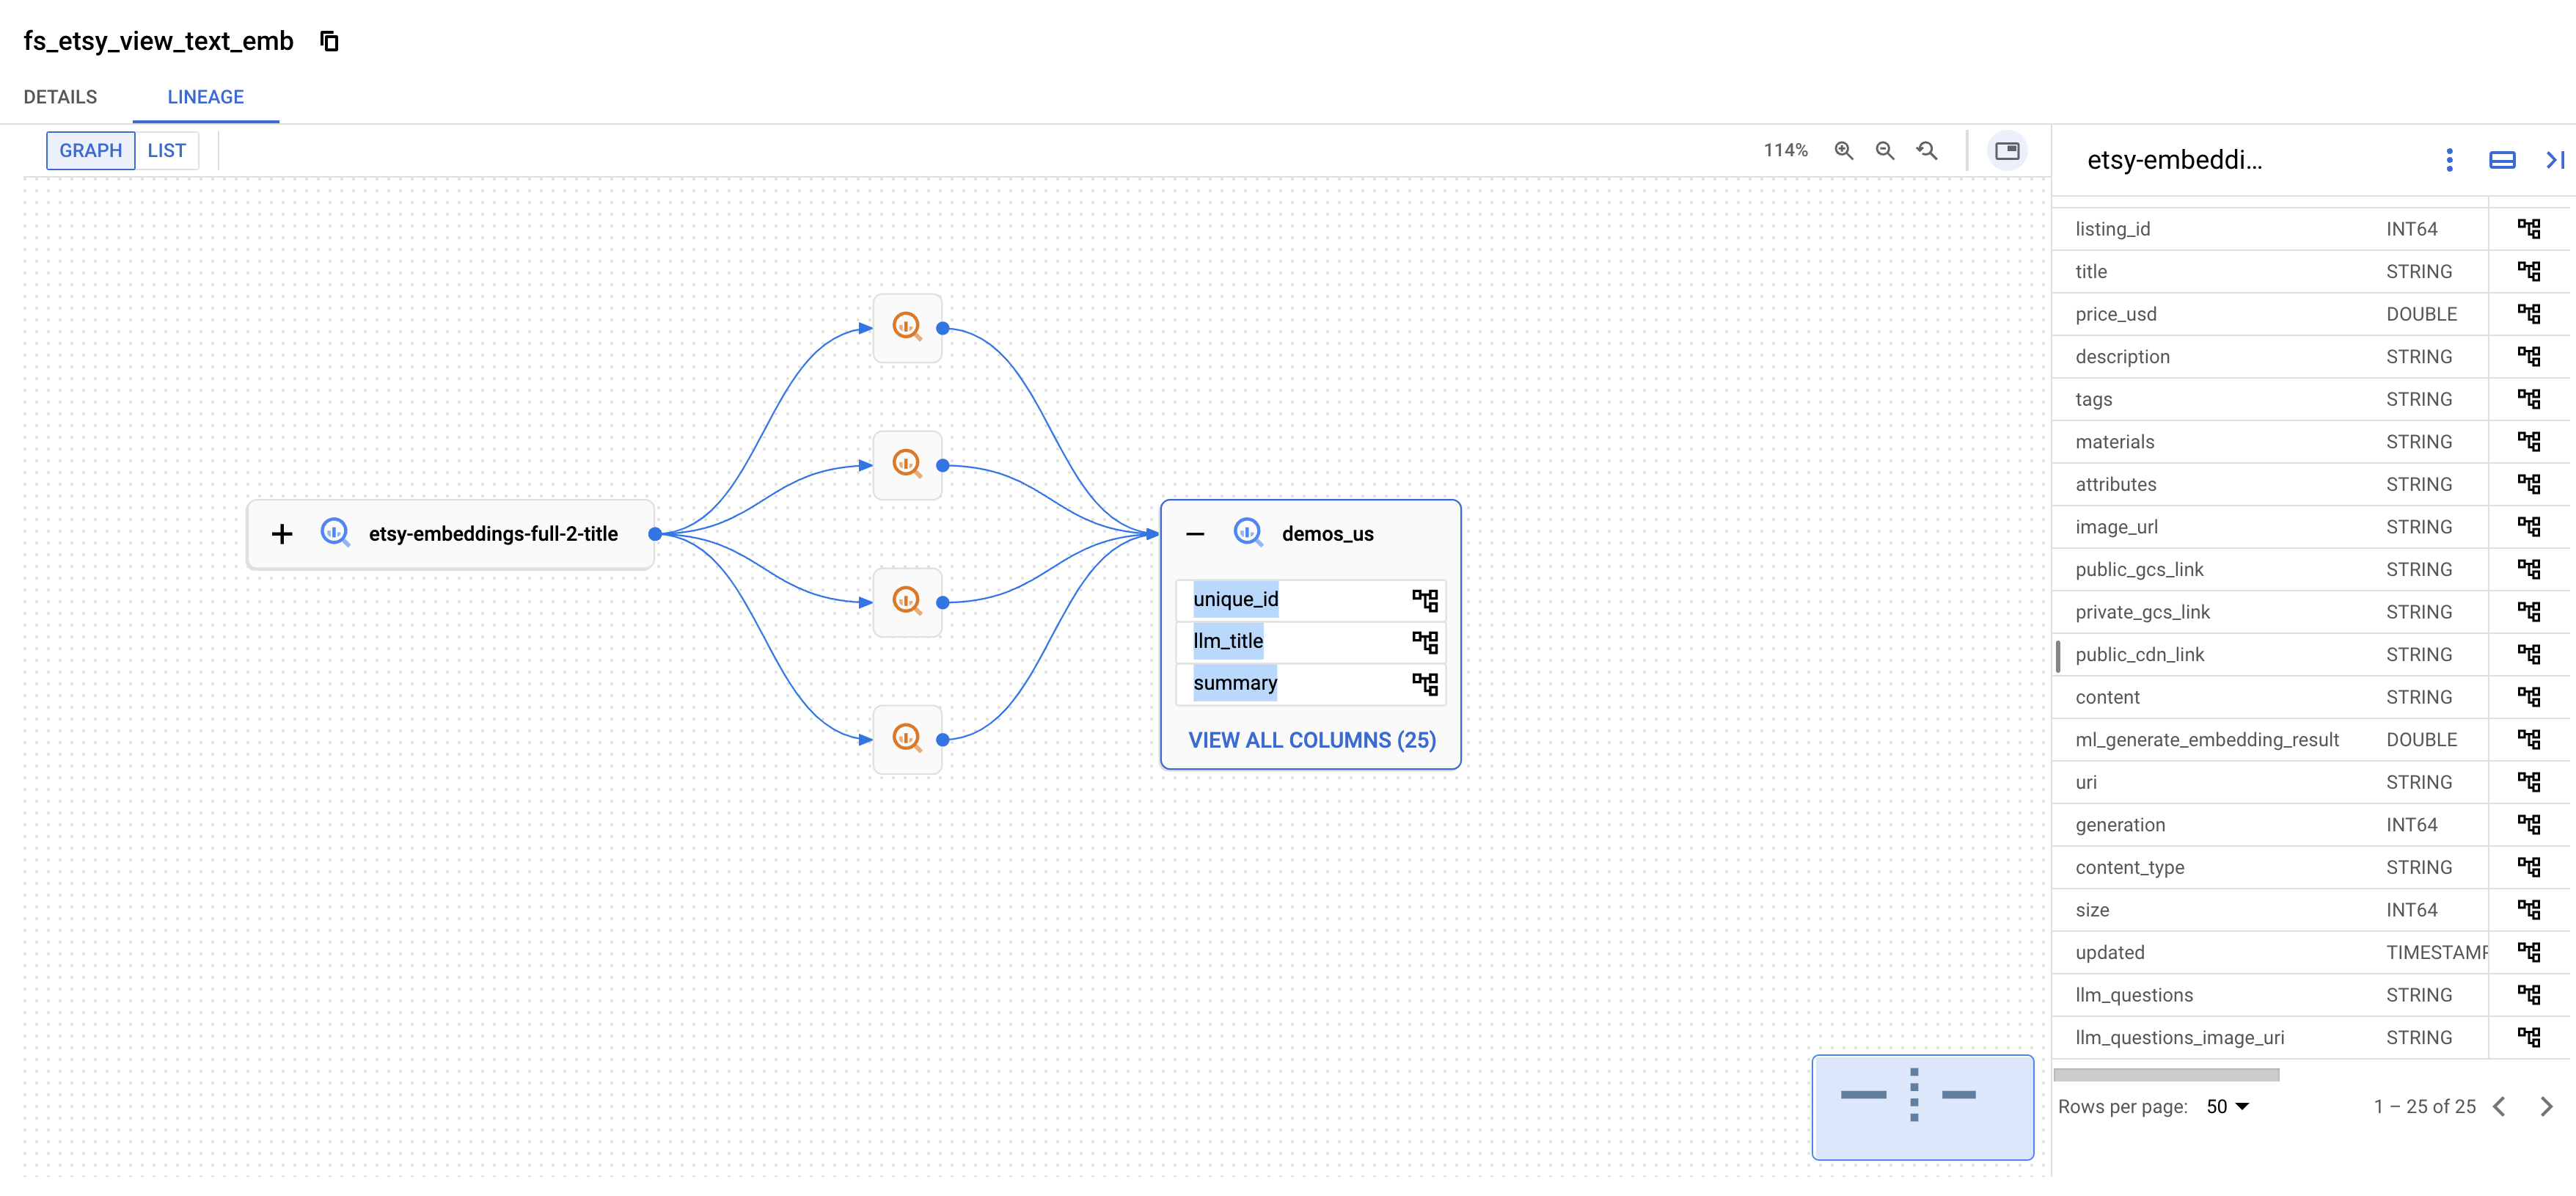